In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import pandas as pd
import seaborn as sn
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = [224, 224]

train_path = 'dataset/train'
valid_path = 'dataset/validation'
test_path = 'dataset/test'

In [4]:
mobile = MobileNet(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [5]:
for layer in mobile.layers:
    layer.trainable = False

In [6]:
folders = glob('dataset/train/*')

In [7]:
x = Flatten()(mobile.output)
x = Dense(1024,activation='relu')(x)

In [8]:
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=prediction)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [10]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dataset = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_dataset = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_dataset = ImageDataGenerator(rescale = 1./255)

In [12]:
training_set = train_dataset.flow_from_directory('dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_set = valid_dataset.flow_from_directory('dataset/validation',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_dataset.flow_from_directory('dataset/test',
                                            target_size = (224, 224),
                                            batch_size = 1,
                                            class_mode = 'categorical')

Found 1960 images belonging to 8 classes.
Found 640 images belonging to 8 classes.
Found 640 images belonging to 8 classes.


In [13]:
r = model.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set)
)

C:\Users\Noman Basar\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
62/62 [==============================] - 424s 7s/step - loss: 3.7050 - accuracy: 0.8750 - val_loss: 0.7470 - val_accuracy: 0.9656
Epoch 2/15
62/62 [==============================] - 401s 6s/step - loss: 0.6521 - accuracy: 0.9699 - val_loss: 1.1906 - val_accuracy: 0.9563
Epoch 3/15
62/62 [==============================] - 398s 6s/step - loss: 0.6011 - accuracy: 0.9704 - val_loss: 0.6570 - val_accuracy: 0.9750
Epoch 4/15
62/62 [==============================] - 429s 7s/step - loss: 0.7704 - accuracy: 0.9724 - val_loss: 1.0438 - val_accuracy: 0.9625
Epoch 5/15
62/62 [==============================] - 405s 7s/step - loss: 0.3304 - accuracy: 0.9847 - val_loss: 0.4876 - val_accuracy: 0.9797
Epoch 6/15
62/62 [==============================] - 427s 7s/step - loss: 0.1247 - accuracy: 0.9908 - val_loss: 0.4114 - val_accuracy: 0.9828
Epoch 7/15
62/62 [==============================] - 439s 7s/step - loss: 0.1771 - accuracy: 0.9903 - val_loss: 0.4070 - val_accuracy: 0.9828
Epoch 8/15
62

In [14]:
from tensorflow.keras.models import load_model

model.save('model_mobilenet.h5')

In [15]:
test_loss,test_acc = model.evaluate(test_set, verbose=2)
print('\nTest accuracy:', test_acc)

640/640 - 104s - loss: 0.1940 - accuracy: 0.9922

Test accuracy: 0.9921875


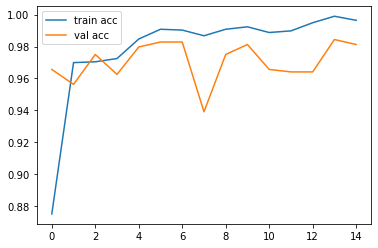

<Figure size 432x288 with 0 Axes>

In [16]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

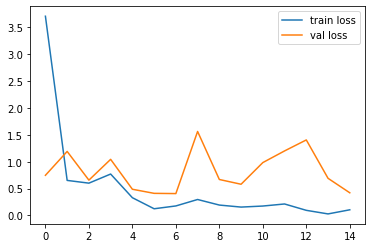

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend() 
plt.show()
plt.savefig('LossVal_loss')

In [18]:
nb_samples = len(test_set)
print(nb_samples)

640


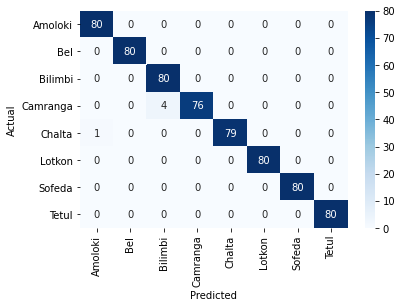

test accuracy : 99.21875


In [19]:
model = tf.keras.models.load_model("model_mobilenet.h5")
filenames = test_set.filenames
#nb_samples = len(test_set)
y_prob=[]
y_act=[]
test_set.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_set.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(training_set.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(training_set.class_indices.keys())[i.argmax()] for i in y_act]


out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

